## Background

DeepLabCut (Mathis et al., 2018) is a deep learning-based tool for markerless pose estimation that enables accurate tracking of animal body parts from video, even with limited manually labeled frames. It has been widely used in neuroscience to study fine-scale motor behaviors like whisking, reaching, or gait. In this project, we applied DeepLabCut to high-speed videos from the DANDI 000231 dataset (Rodgers et al., 2022), which captures mice performing an object recognition task in darkness. Mice were trained to report whether an object was present by licking a water spout, making licks a proxy for their behavioral decision. We used DeepLabCut to track whisker tip and base positions across time and analyzed the resulting whisker angles to test whether object detection is associated with specific whisker movement patterns.


### Imports

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pynwb import read_nwb
from scipy.stats import ttest_ind

## Data Cleaning

We have already run DeepLabCut and generated the coordinates of various points on the whiskers as they move.

In [3]:
whiskers_dlc = pd.read_csv('sub255_croppedDLC_resnet50_BIPN_162May25shuffle1_30000.csv',  header=[1, 2])
whiskers_dlc

bodyparts whisker1_base                        whisker1_middle  \
          coords             x           y likelihood               x   
0              0    600.974731  186.065414   0.997841      437.213989   
1              1    602.406189  178.449844   0.999256      434.575653   
2              2    602.284302  172.767197   0.994995      459.068329   
3              3    602.173828  169.183975   0.997468      469.498627   
4              4    602.131042  166.202942   0.998907      472.936920   
...          ...           ...         ...        ...             ...   
226798    226798      0.000000    0.000000   0.000000        0.000000   
226799    226799      0.000000    0.000000   0.000000        0.000000   
226800    226800      0.000000    0.000000   0.000000        0.000000   
226801    226801      0.000000    0.000000   0.000000        0.000000   
226802    226802      0.000000    0.000000   0.000000        0.000000   

                              whisker1_tip                        ...  \
                 y likelihood            x          y likelihood  ...   
0       103.666832   0.617932   249.233627  39.181095   0.019153  ...   
1        81.270142   0.609417   281.913269  10.555069   0.100040  ...   
2        79.894684   0.815888   324.892151   8.092068   0.389918  ...   
3        78.250900   0.759670   347.101440   6.265535   0.321533  ...   
4        75.245972   0.692284   361.966583   5.318281   0.303206  ...   
...            ...        ...          ...        ...        ...  ...   
226798    0.000000   0.000000     0.000000   0.000000   0.000000  ...   
226799    0.000000   0.000000     0.000000   0.000000   0.000000  ...   
226800    0.000000   0.000000     0.000000   0.000000   0.000000  ...   
226801    0.000000   0.000000     0.000000   0.000000   0.000000  ...   
226802    0.000000   0.000000     0.000000   0.000000   0.000000  ...   

       whisker3_tip whisker4_base                        whisker4_middle  \
         likelihood             x           y likelihood               x   
0          0.833434    597.899902  281.973267   0.999016      555.320435   
1          0.884150    597.676758  280.375732   0.998939      554.053772   
2          0.871929    596.851929  278.762695   0.999297      553.825623   
3          0.888363    596.990112  278.242920   0.999387      553.683350   
4          0.898526    597.007019  277.734100   0.999542      552.878357   
...             ...           ...         ...        ...             ...   
226798     0.000000      0.000000    0.000000   0.000000        0.000000   
226799     0.000000      0.000000    0.000000   0.000000        0.000000   
226800     0.000000      0.000000    0.000000   0.000000        0.000000   
226801     0.000000      0.000000    0.000000   0.000000        0.000000   
226802     0.000000      0.000000    0.000000   0.000000        0.000000   

                              whisker4_tip                         
                 y likelihood            x           y likelihood  
0       285.741211   0.986357   513.500977  297.015747   0.909654  
1       283.932068   0.989262   511.528107  294.665619   0.906051  
2       282.351288   0.989444   510.746002  291.766510   0.936313  
3       281.912354   0.987783   509.819244  291.344788   0.933286  
4       281.806091   0.986887   509.151093  291.084717   0.939975  
...            ...        ...          ...         ...        ...  
226798    0.000000   0.000000     0.000000    0.000000   0.000000  
226799    0.000000   0.000000     0.000000    0.000000   0.000000  
226800    0.000000   0.000000     0.000000    0.000000   0.000000  
226801    0.000000   0.000000     0.000000    0.000000   0.000000  
226802    0.000000   0.000000     0.000000    0.000000   0.000000  

[226803 rows x 37 columns]

The index is currently in terms of frames. We want to convert it to seconds to match the rest of our data. We also only analyzed a cropped section of the original video, so we need to account for the time skip as well. Let's also flatten column names for convenience.

In [4]:
fps = 200
time_skip_mins = 9
time_skip_secs = time_skip_mins * 60

In [5]:
whiskers_dlc[('bodyparts', 'coords')] = whiskers_dlc[('bodyparts', 'coords')] / fps + time_skip_secs
whiskers_dlc = whiskers_dlc.set_index(('bodyparts', 'coords'), drop=True)
whiskers_dlc.index.name = None

In [6]:
whiskers_dlc.columns = ['_'.join(col).strip() for col in whiskers_dlc.columns.values]

In [7]:
whiskers_dlc

,whisker1_base_x,whisker1_base_y,whisker1_base_likelihood,whisker1_middle_x,whisker1_middle_y,whisker1_middle_likelihood,whisker1_tip_x,whisker1_tip_y,whisker1_tip_likelihood,whisker2_base_x,...,whisker3_tip_likelihood,whisker4_base_x,whisker4_base_y,whisker4_base_likelihood,whisker4_middle_x,whisker4_middle_y,whisker4_middle_likelihood,whisker4_tip_x,whisker4_tip_y,whisker4_tip_likelihood
540.000,600.974731,186.065414,0.997841,437.213989,103.666832,0.617932,249.233627,39.181095,0.019153,597.506165,...,0.833434,597.899902,281.973267,0.999016,555.320435,285.741211,0.986357,513.500977,297.015747,0.909654
540.005,602.406189,178.449844,0.999256,434.575653,81.270142,0.609417,281.913269,10.555069,0.100040,597.306213,...,0.884150,597.676758,280.375732,0.998939,554.053772,283.932068,0.989262,511.528107,294.665619,0.906051
540.010,602.284302,172.767197,0.994995,459.068329,79.894684,0.815888,324.892151,8.092068,0.389918,597.859680,...,0.871929,596.851929,278.762695,0.999297,553.825623,282.351288,0.989444,510.746002,291.766510,0.936313
540.015,602.173828,169.183975,0.997468,469.498627,78.250900,0.759670,347.101440,6.265535,0.321533,597.875610,...,0.888363,596.990112,278.242920,0.999387,553.683350,281.912354,0.987783,509.819244,291.344788,0.933286
540.020,602.131042,166.202942,0.998907,472.936920,75.245972,0.692284,361.966583,5.318281,0.303206,597.969421,...,0.898526,597.007019,277.734100,0.999542,552.878357,281.806091,0.986887,509.151093,291.084717,0.939975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673.990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1673.995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1674.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1674.005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We want to get rid of outlier frames that have likelihood lower than 0.9 for all whiskers. The tips of whiskers 1 and 2 frequently go out of frame so we will not consider those.
We will also remove frames where any likelihood value is below 0.5.

In [8]:
likelihoods = ['whisker1_base_likelihood', 'whisker1_middle_likelihood', 
    'whisker2_base_likelihood', 'whisker2_middle_likelihood',
    'whisker3_base_likelihood', 'whisker3_middle_likelihood', 'whisker3_tip_likelihood', 
    'whisker4_base_likelihood', 'whisker4_middle_likelihood', 'whisker4_tip_likelihood']
whiskers_dlc = whiskers_dlc[whiskers_dlc[likelihoods].ge(0.9).any(axis=1)]

bad_whiskers_per_row = whiskers_dlc[likelihoods].lt(0.5).sum(axis=1)
whiskers_dlc = whiskers_dlc[bad_whiskers_per_row < 1]

We can now also drop all likelihood columns since we won't be needing them anymore.

In [10]:
whiskers_dlc = whiskers_dlc.drop(columns = likelihoods + ['whisker1_tip_likelihood', 'whisker2_tip_likelihood'])

----------------------------------------------------------------------------------------------------------------------------------

Now let's look at the nwb file that contains all information about the experimental session. We want the timestamps of when an object was introduced, as well as when the animal performed a lick.

In [76]:
data = read_nwb('sub-255CR_ses-20200322T135448_behavior+ecephys+image.nwb')

/Users/ananyakrishnan/miniconda3/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/ananyakrishnan/miniconda3/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/ananyakrishnan/miniconda3/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [12]:
stimuli = data.trials.to_dataframe()
stimuli

,start_time,stop_time,direct_delivery,stim_is_random,optogenetic,outcome,choice,rewarded_side,servo_position,stimulus,ignore_trial,choice_time,response_window_open_time,trial
id,,,,,,,,,,,,,,
5,19.675,48.460,False,False,False,correct,left,left,medium,nothing,True,44.895,22.705,5
6,48.460,63.400,False,False,False,correct,right,right,close,concave,True,60.203,51.481,6
7,63.400,71.595,False,False,False,correct,left,left,far,nothing,True,68.148,66.430,7
8,71.595,78.495,False,False,False,correct,right,right,close,concave,True,75.037,75.036,8
9,78.495,96.895,False,False,False,error,right,left,far,nothing,True,85.004,81.525,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1899.785,1951.095,False,True,False,spoil,nogo,left,far,nothing,False,NaN,1902.801,248
249,1951.095,2002.275,False,True,False,spoil,nogo,right,far,convex,False,NaN,1954.109,249
250,2002.275,2053.605,False,True,False,spoil,nogo,left,close,nothing,False,NaN,2005.299,250


Let's take a look at what this data is like.

In [13]:
stimuli.dtypes

start_time                   float64
stop_time                    float64
direct_delivery                 bool
stim_is_random                  bool
optogenetic                     bool
outcome                       object
choice                        object
rewarded_side                 object
servo_position                object
stimulus                      object
ignore_trial                    bool
choice_time                  float64
response_window_open_time    float64
trial                          int64
dtype: object

In [14]:
stimuli.nunique()

start_time                   248
stop_time                    248
direct_delivery                1
stim_is_random                 2
optogenetic                    1
outcome                        3
choice                         3
rewarded_side                  2
servo_position                 3
stimulus                       3
ignore_trial                   2
choice_time                  243
response_window_open_time    248
trial                        248
dtype: int64

In [213]:
stimuli['stimulus'].value_counts()

stimulus
nothing    74
convex     40
concave    36
Name: count, dtype: int64

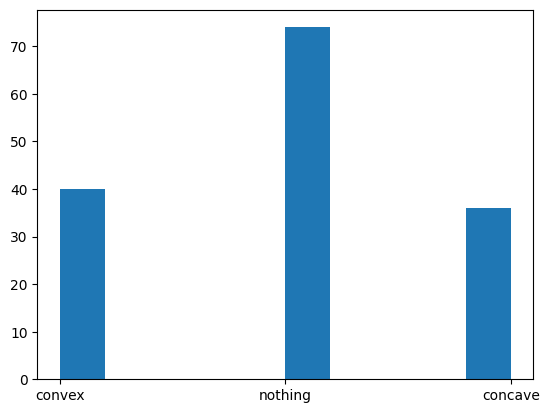

In [28]:
plt.hist(stimuli['stimulus']);

We are only interested in 
- `start_time`: beginning of trial
- `stop_time`: end of trial
- `choice_time`: time of animal performing lick
- `stimulus`: whether concave/convex object was introduced or no object was present

Other columns do not offer any relevant information to our analysis, or have only 1 value so we can drop them. As recommended by the study authors, we will also drop all rows where `ignore_trial` is 'True'. Lastly we will reduce the rows to our cropped timeframe.

In [19]:
stimuli = stimuli[stimuli['ignore_trial']==False]
stimuli = stimuli[['start_time', 'stop_time', 'stimulus', 'choice_time']]
stimuli = stimuli[(stimuli['start_time'] >= whiskers_dlc.index[0]) & (stimuli['start_time'] <= whiskers_dlc.index[-1])]

In [20]:
stimuli

,start_time,stop_time,stimulus,choice_time
id,,,,
70,546.105,553.005,convex,549.232
71,553.005,560.460,nothing,556.547
72,560.460,567.705,nothing,564.027
73,567.705,575.230,nothing,571.762
74,575.230,583.435,convex,579.742
...,...,...,...,...
215,1639.700,1647.030,convex,1643.197
216,1647.030,1654.505,concave,1650.295
217,1654.505,1661.970,nothing,1657.940


Lastly let us obtain the exact contact timepoints of whisker 1 as provided by the authors of the dataset.

In [88]:
contacts_by_whisker_1 = data.processing['behavior'].data_interfaces['contacts_by_whisker_C0'].to_dataframe()
contacts_by_whisker_1

,start_time,stop_time,base_x,base_y,tip_x,tip_y,angle,frame_start,frame_stop,duration_frames
id,,,,,,,,,,
0,60.160,60.175,598.049521,260.796733,152.751962,259.708173,-0.147393,12032,12035,4
1,74.660,74.670,597.101849,254.898721,222.024102,297.290538,6.684866,14932,14934,3
2,74.705,74.720,599.000965,254.144156,162.900853,264.341509,1.329106,14941,14944,4
3,74.805,74.810,600.085265,235.245543,129.425289,244.204750,1.151027,14961,14962,2
4,75.005,75.010,598.902574,239.327259,174.549392,272.398164,4.450224,15001,15002,2
...,...,...,...,...,...,...,...,...,...,...
255,2092.390,2092.405,599.412229,284.436205,264.782610,405.554869,20.114593,418478,418481,4
256,2098.775,2098.805,599.561220,277.686570,166.232786,361.354054,10.917947,419755,419761,7
257,2099.000,2099.020,598.600838,276.750511,224.981278,387.351196,16.992093,419800,419804,5


## Exploratory Data Analysis

Now we can generate the features we want to explore - whisker angle of deflection (from a vertical axis). 

We calculate this by finding the vector of a whisker from either its tip (for whiskers 3&4) or middle (for whiskers 1&2) to its base. We then calculate the angle between the whisker vector and a vertical axis vector([0, 1]) by using the dot product.

                                                            θ = arccos((w · v) / ||w||)
where w is the whisker vector and v is the vertical reference vector (0,1).

In [21]:
def find_whisker_vector(whisker_num, df):
    x1 = df[f'whisker{whisker_num}_base_x']
    y1 = df[f'whisker{whisker_num}_base_y']

    if whisker_num < 3:
        x2 = df[f'whisker{whisker_num}_middle_x']
        y2 = df[f'whisker{whisker_num}_middle_y']
    else:
        x2 = df[f'whisker{whisker_num}_tip_x']
        y2 = df[f'whisker{whisker_num}_tip_y']
    
    dx = x2 - x1
    dy = y2 - y1
    return np.column_stack([dx, dy])

In [23]:
def whisker_angle(whisker_num, df):
    vectors = find_whisker_vector(whisker_num, df)
    vertical = np.array([0, 1])
    
    dot_prod = np.dot(vectors, vertical)
    norms = np.linalg.norm(vectors, axis=1)
    
    valid_mask = norms > 0
    cos_theta = np.full(len(norms), np.nan)
    cos_theta[valid_mask] = np.clip(dot_prod[valid_mask] / norms[valid_mask], -1.0, 1.0)
    
    return np.degrees(np.arccos(cos_theta))

In [24]:
whisker1_angle = whisker_angle(1, whiskers_dlc)
whisker2_angle = whisker_angle(2, whiskers_dlc)
whisker3_angle = whisker_angle(3, whiskers_dlc)
whisker4_angle = whisker_angle(4, whiskers_dlc)
avg_whisker_angle = np.mean([whisker1_angle, whisker2_angle, whisker3_angle, whisker4_angle], axis = 0)

We can now append these features to our dataframe. `avg_whisker_angle` is the average angle of all 4 whiskers for each time point.

In [25]:
whiskers_dlc = whiskers_dlc.assign(whisker1_angle = whisker1_angle,
                   whisker2_angle = whisker2_angle,
                   whisker3_angle = whisker3_angle,
                   whisker4_angle = whisker4_angle,
                   avg_whisker_angle = avg_whisker_angle)

Now we can finally see what whisker deflection looks and how that lines up with the type of stimuli and time of licking('choice_time').

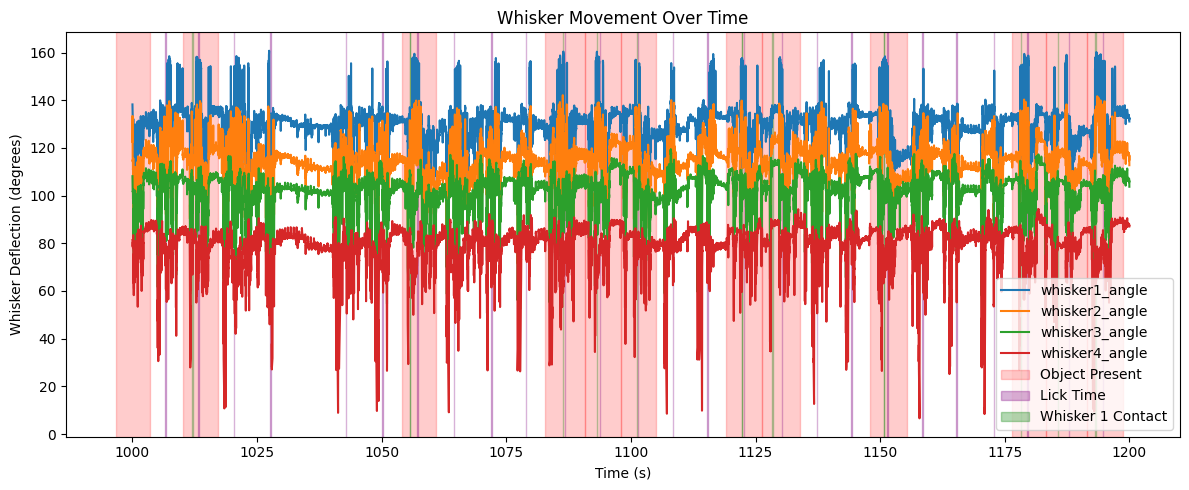

In [90]:
cols = [
    'whisker1_angle',
    'whisker2_angle',
    'whisker3_angle',
    'whisker4_angle',
]

start, end = 1000, 1200  # change as needed
subset = whiskers_dlc.loc[start:end, cols]

ax = subset.plot(figsize=(12, 5))
plt.xlabel("Time (s)")
plt.ylabel("Whisker Deflection (degrees)")
plt.title("Whisker Movement Over Time")

stimulus_added = False
for s, e in zip(stimuli['start_time'][stimuli['stimulus'] != 'nothing'], stimuli['stop_time'][stimuli['stimulus'] != 'nothing']):
    if e >= start and s <= end:  
        if not stimulus_added:
            plt.axvspan(s, e, color='red', alpha=0.2, label='Object Present')
            stimulus_added = True
        else:
            plt.axvspan(s, e, color='red', alpha=0.2)

choice_added = False
for c in stimuli['choice_time']:
    if start <= c <= end:
        if not choice_added:
            plt.axvspan(c, c + 0.1, color='purple', alpha=0.3, label='Lick Time')
            choice_added = True
        else:
            plt.axvspan(c, c + 0.1, color='purple', alpha=0.3)

contact_added = False
for s, e in zip(contacts_by_whisker_1['start_time'], contacts_by_whisker_1['stop_time']):
    if e >= start and s <= end:
        if not contact_added:
            plt.axvspan(s, e, color='green', alpha=0.3, label='Whisker 1 Contact')
            contact_added = True
        else:
            plt.axvspan(s, e, color='green', alpha=0.3)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

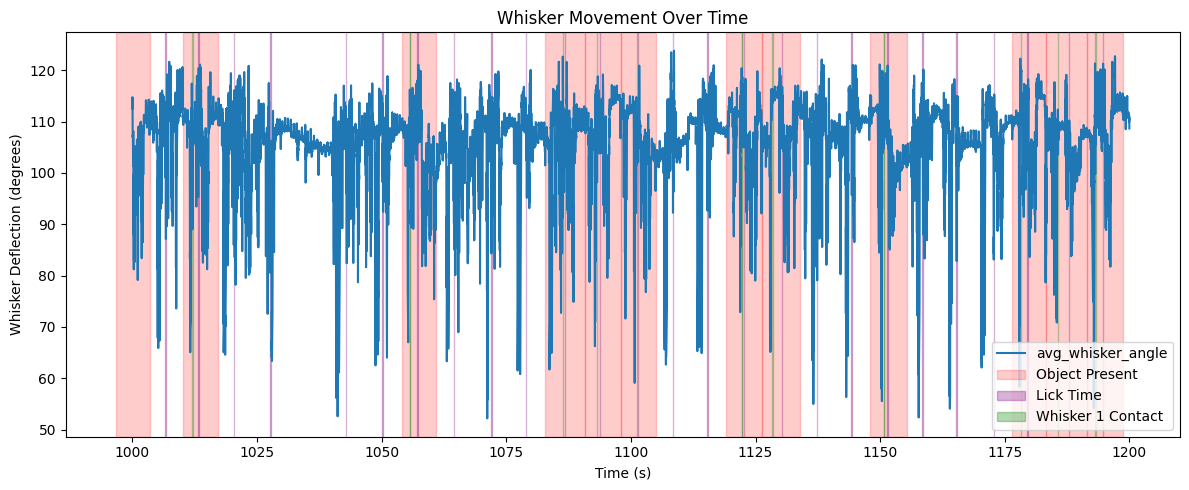

In [91]:
cols = [
    'avg_whisker_angle'
]

start, end = 1000, 1200  # change as needed
subset = whiskers_dlc.loc[start:end, cols]

ax = subset.plot(figsize=(12, 5))
plt.xlabel("Time (s)")
plt.ylabel("Whisker Deflection (degrees)")
plt.title("Whisker Movement Over Time")

stimulus_added = False
for s, e in zip(stimuli['start_time'][stimuli['stimulus'] != 'nothing'], stimuli['stop_time'][stimuli['stimulus'] != 'nothing']):
    if e >= start and s <= end:  
        if not stimulus_added:
            plt.axvspan(s, e, color='red', alpha=0.2, label='Object Present')
            stimulus_added = True
        else:
            plt.axvspan(s, e, color='red', alpha=0.2)

choice_added = False
for c in stimuli['choice_time']:
    if start <= c <= end:
        if not choice_added:
            plt.axvspan(c, c + 0.1, color='purple', alpha=0.3, label='Lick Time')
            choice_added = True
        else:
            plt.axvspan(c, c + 0.1, color='purple', alpha=0.3)

contact_added = False
for s, e in zip(contacts_by_whisker_1['start_time'], contacts_by_whisker_1['stop_time']):
    if e >= start and s <= end:
        if not contact_added:
            plt.axvspan(s, e, color='green', alpha=0.3, label='Whisker 1 Contact')
            contact_added = True
        else:
            plt.axvspan(s, e, color='green', alpha=0.3)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Observations:
- Periods of very strong downwards whisker deflection almost perfectly line up with licks.
- While there does appear to be some increased whisking at contact with whisker 1, it is not the strongest whisking.
- Strength of whisks is strongest in whisker 1 and reduces from whisker 1 to 4.

Let us take a closer look at just whisker 1 now.

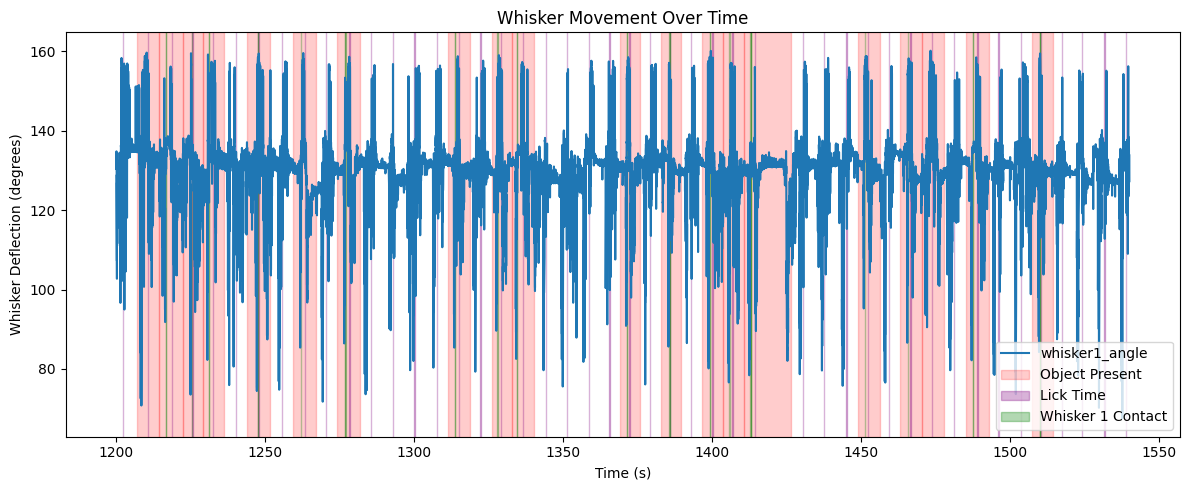

In [92]:
cols = [
    'whisker1_angle'
]

start, end = 1200, 1540  # change as needed
subset = whiskers_dlc.loc[start:end, cols]

ax = subset.plot(figsize=(12, 5))
plt.xlabel("Time (s)")
plt.ylabel("Whisker Deflection (degrees)")
plt.title("Whisker Movement Over Time")

stimulus_added = False
for s, e in zip(stimuli['start_time'][stimuli['stimulus'] != 'nothing'], stimuli['stop_time'][stimuli['stimulus'] != 'nothing']):
    if e >= start and s <= end:  
        if not stimulus_added:
            plt.axvspan(s, e, color='red', alpha=0.2, label='Object Present')
            stimulus_added = True
        else:
            plt.axvspan(s, e, color='red', alpha=0.2)

choice_added = False
for c in stimuli['choice_time']:
    if start <= c <= end:
        if not choice_added:
            plt.axvspan(c, c + 0.1, color='purple', alpha=0.3, label='Lick Time')
            choice_added = True
        else:
            plt.axvspan(c, c + 0.1, color='purple', alpha=0.3)

contact_added = False
for s, e in zip(contacts_by_whisker_1['start_time'], contacts_by_whisker_1['stop_time']):
    if e >= start and s <= end:
        if not contact_added:
            plt.axvspan(s, e, color='green', alpha=0.3, label='Whisker 1 Contact')
            contact_added = True
        else:
            plt.axvspan(s, e, color='green', alpha=0.3)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

The plot again shows increased whisking during whisker 1 contact, with the most intense whisking occurring around licks. We had aimed to distinguish whisking triggered by object detection using contact data, but this was complicated by frequent licks, even when no object was present, which consistently coincide with strong whisking. This overlap makes it difficult to isolate baseline whisking and assess the effect of object presence alone.

However, visual inspection of the whisker movement data suggests a more subtle pattern — whisking during licks appears stronger when objects are present than when they are absent. To test whether this observation is statistically significant, we perform a t-test comparing whisker deflection angles during licking periods across different sensory conditions.

Because whisking is closely coupled with licking behavior, we use lick times as markers of active whisking. For each lick event, we extract whisker deflection angles within a 200 ms window (±100 ms) to capture the full whisking bout.

## Statistical Test

In [74]:
def test_stat(whisker_num, time_frame=0.1):
    whisker_col = f'whisker{whisker_num}_angle'
    
    object_angles = []
    object_lick_times = stimuli['choice_time'][stimuli['stimulus'] != 'nothing']
    for t in object_lick_times:
        window = whiskers_dlc[whisker_col][(whiskers_dlc.index > t - time_frame) & 
                                         (whiskers_dlc.index < t + time_frame)]
        if len(window) > 0: 
            object_angles.append(np.mean(window))
    
    nothing_angles = []
    nothing_lick_times = stimuli['choice_time'][stimuli['stimulus'] == 'nothing']
    for t in nothing_lick_times:
        window = whiskers_dlc[whisker_col][(whiskers_dlc.index > t - time_frame) & 
                                         (whiskers_dlc.index < t + time_frame)]
        if len(window) > 0: 
            nothing_angles.append(np.mean(window))
    
    return np.array(object_angles), np.array(nothing_angles)

We can now compared the mean whisker angles between two conditions: trials with objects present (concave or convex) versus trials with no objects present. 

Let us perform a t-test using a significance level of α = 0.05.
                                                       
**Hypothesis:**

- H0: There is no difference in whisking when an object is present or absent.
- H1: The presence of an object affects whisking intensity during the licking period, with greater whisker deflection when an object is present compared to when it is absent.

In [67]:
def t_test(obj_arr, nothing_arr):
    t_stat, p_val = ttest_ind(obj_arr, nothing_arr, equal_var=False)
    p_val_one_sided = p_val / 2 if t_stat > 0 else 1 - (p_val / 2)
        
    print(f"t = {t_stat:.3f}, one-sided p = {p_val_one_sided:.5f}, Object mean = {np.mean(obj_arr):.2f}, No object mean = {np.mean(nothing_arr):.2f}")
    print(f'Reject null hypothesis') if p_val_one_sided < 0.05 else print('Fail to reject null hypothesis')


In [68]:
whisker1_object, whisker1_nothing = test_stat(1)
t_test(whisker1_object, whisker1_nothing)

t = 8.958, one-sided p = 0.00000, Object mean = 139.80, No object mean = 131.44
Reject null hypothesis


In [69]:
whisker2_object, whisker2_nothing = test_stat(2)
t_test(whisker2_object, whisker2_nothing)

t = 7.161, one-sided p = 0.00000, Object mean = 125.07, No object mean = 117.73
Reject null hypothesis


In [70]:
whisker3_object, whisker3_nothing = test_stat(3)
t_test(whisker3_object, whisker3_nothing)

t = -1.585, one-sided p = 0.94231, Object mean = 102.84, No object mean = 104.10
Fail to reject null hypothesis


In [71]:
whisker4_object, whisker4_nothing = test_stat(4)
t_test(whisker4_object, whisker4_nothing)

t = -1.155, one-sided p = 0.87473, Object mean = 77.06, No object mean = 77.91
Fail to reject null hypothesis


Let us also check for average whisker angle:

In [72]:
whisker_col = 'avg_whisker_angle'
time_frame = 0.1
object_angles = []
object_lick_times = stimuli['choice_time'][stimuli['stimulus'] != 'nothing']
for t in object_lick_times:
    window = whiskers_dlc[whisker_col][(whiskers_dlc.index > t - time_frame) & 
                                     (whiskers_dlc.index < t + time_frame)]
    if len(window) > 0: 
        object_angles.append(np.mean(window))

# For 'nothing' trials
nothing_angles = []
nothing_lick_times = stimuli['choice_time'][stimuli['stimulus'] == 'nothing']
for t in nothing_lick_times:
    window = whiskers_dlc[whisker_col][(whiskers_dlc.index > t - time_frame) & 
                                     (whiskers_dlc.index < t + time_frame)]
    if len(window) > 0: 
        nothing_angles.append(np.mean(window))

avg_object, avg_nothing = np.array(object_angles), np.array(nothing_angles)
t_test(avg_object, avg_nothing)

t = 4.464, one-sided p = 0.00001, Object mean = 111.19, No object mean = 107.80
Reject null hypothesis


## Results

The difference in whisking between object-present and object-absent trials was statistically significant for whiskers 1, 2, and the average across all four whiskers. In contrast, whiskers 3 and 4 showed no significant difference, likely due to their more limited range of motion, which may have reduced sensitivity to object-driven modulation.

## Discussion

Our results show that whisker movement is greater when an object is present to detect, compared to when there isn’t one. This is interesting because licking happens in both cases, so the difference in whisking doesn’t seem to be just due to the motor program for licking. Instead, it suggests that whisking is being modulated by whether or not there’s something to sense.

One important thing to note is that strong whisking and licking happen around the same time, so we assumed that the observed whisker movement is linked to the lick itself. But the fact that there’s still a clear difference in whisking based on object presence, even when the licking behavior is the same, supports the idea that whisking is adjusted based on sensory context.

Whiskers 1 and 2 showed the strongest effects, likely because they had the most movement range. Whiskers 3 and 4 had more limited motion, which may explain why they didn’t show a significant difference.

Overall, this suggests that whisking isn’t just automatic during the lick, it’s also influenced by whether there’s actually something there to explore.

## Limitations

One limitation of this analysis is the overlap between whisking and licking, which makes it hard to separate sensory-driven whisker movement from movement tied to the motor act of licking. The time window used also only captures whisking during licking, and does not include the time leading up to object contact, potentially affecting the results. Additionally, grouping all object-present trials together may overlook subtle differences between concave and convex object types. Lastly, about 13% of the whisker tracking data was dropped during cleaning, which could introduce bias. 
